# Figures 3 & 4: Nino3.4 SST Skill (correlation & nRMSE) & DJF Time Series

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Create Dask Cluster

In [3]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

NameError: name 'cluster' is not defined

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
cluster

### Read in POP monthly SST field using I/O functions; Convert to seasonal mean

In [9]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    d0 = d0.chunk({'L':-1})
    return d0

In [10]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 29.4 s, sys: 11.6 s, total: 41 s
Wall time: 1min 16s


11.799439476

In [11]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 1min 5s, sys: 1.57 s, total: 1min 6s
Wall time: 1min 49s


In [12]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 2
chunk = {}
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 34.1 s, sys: 12 s, total: 46.2 s
Wall time: 1min 15s


11.799439476

In [13]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 1min 13s, sys: 1.58 s, total: 1min 15s
Wall time: 1min 47s


In [14]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 5
chunk = {}
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

CPU times: user 38.4 s, sys: 12.1 s, total: 50.5 s
Wall time: 1min 16s


11.799439476

In [15]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 1min 20s, sys: 1.56 s, total: 1min 21s
Wall time: 1min 52s


In [16]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 8
chunk = {}
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

CPU times: user 45.8 s, sys: 12.3 s, total: 58.1 s
Wall time: 1min 25s


11.799439476

In [17]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 1min 22s, sys: 1.51 s, total: 1min 23s
Wall time: 1min 50s


# Compute Regional-average SST

### Define Averaging Region

In [3]:
#lon-w, lon-e, lat-s, lat-n:
regionlonlat = [-170.,-120.,-5.,5.]  
regiontitle = 'Nino3.4'

In [4]:
def POP_regional_areawgt(ds,lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [5]:
POPg16_regsst_area = POP_regional_areawgt(smyle11,regionlonlat)

NameError: name 'smyle11' is not defined

### Perform regional-average computation on SMYLE, returning xarray:

In [32]:
%%time
smyle11_seas_regsst = smyle11_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle02_seas_regsst = smyle02_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle05_seas_regsst = smyle05_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle08_seas_regsst = smyle08_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 42s, sys: 2.01 s, total: 2min 44s
Wall time: 2min 53s


In [33]:
%%time
smyle11_regsst = smyle11.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle02_regsst = smyle02.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle05_regsst = smyle05.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle08_regsst = smyle08.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 40s, sys: 3.22 s, total: 2min 44s
Wall time: 4min 41s


### Store datasets to disk for quicker processing next time 

In [34]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()
smyle11_time = smyle11.time.load()
smyle02_time = smyle02.time.load()
smyle05_time = smyle05.time.load()
smyle08_time = smyle08.time.load()

CPU times: user 684 µs, sys: 0 ns, total: 684 µs
Wall time: 688 µs


In [35]:
smyle11_seas_regsst = smyle11_seas_regsst.drop('z_t').rename('sst')
smyle02_seas_regsst = smyle02_seas_regsst.drop('z_t').rename('sst')
smyle05_seas_regsst = smyle05_seas_regsst.drop('z_t').rename('sst')
smyle08_seas_regsst = smyle08_seas_regsst.drop('z_t').rename('sst')
smyle11_regsst = smyle11_regsst.drop('z_t').rename('sst')
smyle02_regsst = smyle02_regsst.drop('z_t').rename('sst')
smyle05_regsst = smyle05_regsst.drop('z_t').rename('sst')
smyle08_regsst = smyle08_regsst.drop('z_t').rename('sst')

ds_smyle11_seas_regsst = smyle11_seas_regsst.to_dataset()
ds_smyle11_seas_regsst['time'] = smyle11_seas_time
ds_smyle02_seas_regsst = smyle02_seas_regsst.to_dataset()
ds_smyle02_seas_regsst['time'] = smyle02_seas_time
ds_smyle05_seas_regsst = smyle05_seas_regsst.to_dataset()
ds_smyle05_seas_regsst['time'] = smyle05_seas_time
ds_smyle08_seas_regsst = smyle08_seas_regsst.to_dataset()
ds_smyle08_seas_regsst['time'] = smyle08_seas_time

ds_smyle11_regsst = smyle11_regsst.to_dataset()
ds_smyle11_regsst['time'] = smyle11_time
ds_smyle02_regsst = smyle02_regsst.to_dataset()
ds_smyle02_regsst['time'] = smyle02_time
ds_smyle05_regsst = smyle05_regsst.to_dataset()
ds_smyle05_regsst['time'] = smyle05_time
ds_smyle08_regsst = smyle08_regsst.to_dataset()
ds_smyle08_regsst['time'] = smyle08_time

In [36]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds_smyle11_seas_regsst.to_netcdf(outdir+'SMYLE11_Nino3.4SST_seas.nc')
ds_smyle02_seas_regsst.to_netcdf(outdir+'SMYLE02_Nino3.4SST_seas.nc')
ds_smyle05_seas_regsst.to_netcdf(outdir+'SMYLE05_Nino3.4SST_seas.nc')
ds_smyle08_seas_regsst.to_netcdf(outdir+'SMYLE08_Nino3.4SST_seas.nc')
ds_smyle11_regsst.to_netcdf(outdir+'SMYLE11_Nino3.4SST_mon.nc')
ds_smyle02_regsst.to_netcdf(outdir+'SMYLE02_Nino3.4SST_mon.nc')
ds_smyle05_regsst.to_netcdf(outdir+'SMYLE05_Nino3.4SST_mon.nc')
ds_smyle08_regsst.to_netcdf(outdir+'SMYLE08_Nino3.4SST_mon.nc')

CPU times: user 409 ms, sys: 18 ms, total: 427 ms
Wall time: 515 ms


In [5]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds_smyle11_seas_regsst = xr.open_dataset(outdir+'SMYLE11_Nino3.4SST_seas.nc')
smyle11_seas_time = ds_smyle11_seas_regsst['time']
smyle11_seas_regsst = ds_smyle11_seas_regsst['sst']

ds_smyle02_seas_regsst = xr.open_dataset(outdir+'SMYLE02_Nino3.4SST_seas.nc')
smyle02_seas_time = ds_smyle02_seas_regsst['time']
smyle02_seas_regsst = ds_smyle02_seas_regsst['sst']

ds_smyle05_seas_regsst = xr.open_dataset(outdir+'SMYLE05_Nino3.4SST_seas.nc')
smyle05_seas_time = ds_smyle05_seas_regsst['time']
smyle05_seas_regsst = ds_smyle05_seas_regsst['sst']

ds_smyle08_seas_regsst = xr.open_dataset(outdir+'SMYLE08_Nino3.4SST_seas.nc')
smyle08_seas_time = ds_smyle08_seas_regsst['time']
smyle08_seas_regsst = ds_smyle08_seas_regsst['sst']

ds_smyle11_regsst = xr.open_dataset(outdir+'SMYLE11_Nino3.4SST_mon.nc')
smyle11_time = ds_smyle11_regsst['time']
smyle11_regsst = ds_smyle11_regsst['sst']

ds_smyle02_regsst = xr.open_dataset(outdir+'SMYLE02_Nino3.4SST_mon.nc')
smyle02_time = ds_smyle02_regsst['time']
smyle02_regsst = ds_smyle02_regsst['sst']

ds_smyle05_regsst = xr.open_dataset(outdir+'SMYLE05_Nino3.4SST_mon.nc')
smyle05_time = ds_smyle05_regsst['time']
smyle05_regsst = ds_smyle05_regsst['sst']

ds_smyle08_regsst = xr.open_dataset(outdir+'SMYLE08_Nino3.4SST_mon.nc')
smyle08_time = ds_smyle08_regsst['time']
smyle08_regsst = ds_smyle08_regsst['sst']

### Compute observed monthly and seasonal anomalies

In [6]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

In [7]:
# Note that latitude decreases with index in this dataset!
ds_hadisst = ds_hadisst.rename({"latitude":"lat","longitude":"lon"})
ds_hadisst = ds_hadisst.reindex(lat=ds_hadisst.lat[::-1])

In [8]:
tmp = ds_hadisst.sst.sel(lat=slice(regionlonlat[2],regionlonlat[3])).sel(lon=slice(regionlonlat[0],regionlonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_mon = tmp.weighted(wgts).mean(("lon", "lat"))

In [9]:
obs_seas = obs_mon.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

### NMME forecast anomalies

In [10]:
#Decodes time dimension to CFTime standards."""
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [11]:
%%time
# NMME Forecasts SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
modelnames = ['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4','GFDL-CM2p1-aer04',\
              'GFDL-CM2p5-FLOR-A06','GFDL-CM2p5-FLOR-B01','NASA-GMAO-062012','NCEP-CFSv2']
nmmelist = []
for i in range(8):
    field = 'sst'
    datadir = '/glade/work/xianwu/data/model/nmme/'    #The NMME SST data was from IRI
    casename = field+'-'+modelnames[i]
    filetemplate = datadir+casename+'.nc'
    ds_nmme = xr.open_dataset(filetemplate,decode_times=False)
    ds_nmme = ds_nmme.sel(S=slice('264','684'))   #198201(264)-201612(684)
    ds_nmme = decode_cf(ds_nmme, 'S')
    tmp_nmme = ds_nmme.sst.sel(Y=slice(regionlonlat[2],regionlonlat[3])).sel(X=slice(regionlonlat[0]+360,regionlonlat[1]+370))
    wgts_nmme = np.cos(np.deg2rad(tmp_nmme.Y))
    nmme_regsst = tmp_nmme.weighted(wgts_nmme).mean(("X", "Y")).load()   
    mem = ds_nmme.sizes['M']
    print('{}:'.format(i)+modelnames[i]+' M={}'.format(mem))
    #remove climatology
    if((modelnames[i] == 'COLA-RSMAS-CCSM4') | (modelnames[i] == 'NCEP-CFSv2')):   #two-period climatology definition for these two models according to Barnston et al. 2019
        sst1 = nmme_regsst.sel(S=slice('1982-01-01', '1998-12-01'))
        ssta1 = sst1.groupby('S.month') - sst1.groupby('S.month').mean(('S', 'M'))
        
        sst2 = nmme_regsst.sel(S=slice('1999-01-01', '2016-12-01'))
        ssta2 = sst2.groupby('S.month') - sst2.groupby('S.month').mean(('S', 'M'))
        nmme_regsst = xr.concat([ssta1, ssta2], dim='S')
    else:
        nmme_regsst = nmme_regsst.groupby('S.month') - nmme_regsst.groupby('S.month').mean(('S','M'))
    nmmelist.append(nmme_regsst) 
nmme_regsst = xr.concat(nmmelist,dim="model")

0:CMC1-CanCM3 M=10
1:CMC2-CanCM4 M=10
2:COLA-RSMAS-CCSM4 M=10
3:GFDL-CM2p1-aer04 M=10
4:GFDL-CM2p5-FLOR-A06 M=12
5:GFDL-CM2p5-FLOR-B01 M=12
6:NASA-GMAO-062012 M=12
7:NCEP-CFSv2 M=28
CPU times: user 4.64 s, sys: 7.1 s, total: 11.7 s
Wall time: 21.1 s


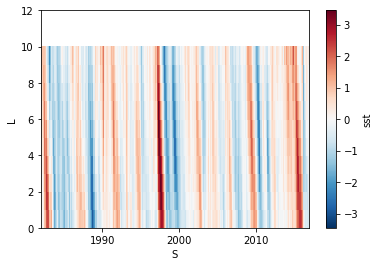

In [12]:
nmme_regsst.isel(model=7).mean('M').plot(x='S')
#nmme_regsst_all.mean('model').plot(x='S')

In [13]:
# Put NMME data into SMYLE-like format:
nmme_time = nmme_regsst.S
month = nmme_time.dt.month
year = nmme_time.dt.year

#select the four start months as in SMYLE
timekeep = nmme_time.where((month == 11)).dropna('S')
nmme11_regsst = nmme_regsst.sel(S=timekeep).rename({'S': 'Y'})
nmme11_regsst = nmme11_regsst.assign_coords({"Y":nmme11_regsst.Y.dt.year})
nmme11_regsst = nmme11_regsst.assign_coords({"L":np.arange(nmme11_regsst.sizes["L"])+1})

timekeep = nmme_time.where((month == 2)).dropna('S')
nmme02_regsst = nmme_regsst.sel(S=timekeep).rename({'S': 'Y'})
nmme02_regsst = nmme02_regsst.assign_coords({"Y":nmme02_regsst.Y.dt.year})
nmme02_regsst = nmme02_regsst.assign_coords({"L":np.arange(nmme02_regsst.sizes["L"])+1})

timekeep = nmme_time.where((month == 5)).dropna('S')
nmme05_regsst = nmme_regsst.sel(S=timekeep).rename({'S': 'Y'})
nmme05_regsst = nmme05_regsst.assign_coords({"Y":nmme05_regsst.Y.dt.year})
nmme05_regsst = nmme05_regsst.assign_coords({"L":np.arange(nmme05_regsst.sizes["L"])+1})

timekeep = nmme_time.where((month == 8)).dropna('S')
nmme08_regsst = nmme_regsst.sel(S=timekeep).rename({'S': 'Y'})
nmme08_regsst = nmme08_regsst.assign_coords({"Y":nmme08_regsst.Y.dt.year})
nmme08_regsst = nmme08_regsst.assign_coords({"L":np.arange(nmme08_regsst.sizes["L"])+1})

In [14]:
# Create SMYLE-like datasets with verification time for seasonal averaging
ds_nmme11_regsst = nmme11_regsst.to_dataset()
ds_nmme11_regsst['time'] = smyle11_time.sel(Y=nmme11_regsst.Y)
nmme11_seas_regsst = cal.mon_to_seas_dask(ds_nmme11_regsst).sst

ds_nmme02_regsst = nmme02_regsst.to_dataset()
ds_nmme02_regsst['time'] = smyle02_time.sel(Y=nmme02_regsst.Y)
nmme02_seas_regsst = cal.mon_to_seas_dask(ds_nmme02_regsst).sst

ds_nmme05_regsst = nmme05_regsst.to_dataset()
ds_nmme05_regsst['time'] = smyle05_time.sel(Y=nmme05_regsst.Y)
nmme05_seas_regsst = cal.mon_to_seas_dask(ds_nmme05_regsst).sst

ds_nmme08_regsst = nmme08_regsst.to_dataset()
ds_nmme08_regsst['time'] = smyle08_time.sel(Y=nmme08_regsst.Y)
nmme08_seas_regsst = cal.mon_to_seas_dask(ds_nmme08_regsst).sst

In [15]:
nmme11_time = smyle11_time.sel(Y=nmme11_regsst.Y)
nmme02_time = smyle02_time.sel(Y=nmme02_regsst.Y)
nmme05_time = smyle05_time.sel(Y=nmme05_regsst.Y)
nmme08_time = smyle08_time.sel(Y=nmme08_regsst.Y)
nmme11_seas_time = smyle11_seas_time.sel(Y=nmme11_seas_regsst.Y)
nmme02_seas_time = smyle02_seas_time.sel(Y=nmme02_seas_regsst.Y)
nmme05_seas_time = smyle05_seas_time.sel(Y=nmme05_seas_regsst.Y)
nmme08_seas_time = smyle08_seas_time.sel(Y=nmme08_seas_regsst.Y)

# Skill Analysis

In [16]:
%%time
# Remove leadtime-dependent climatology
climy0 = 1982
climy1 = 2016
smyle11_seas_regsst_dd,smyle11_seas_regsst_drift = stats.remove_drift(smyle11_seas_regsst,smyle11_seas_time,climy0,climy1)
smyle02_seas_regsst_dd,smyle02_seas_regsst_drift = stats.remove_drift(smyle02_seas_regsst,smyle02_seas_time,climy0,climy1)
smyle05_seas_regsst_dd,smyle05_seas_regsst_drift = stats.remove_drift(smyle05_seas_regsst,smyle05_seas_time,climy0,climy1)
smyle08_seas_regsst_dd,smyle08_seas_regsst_drift = stats.remove_drift(smyle08_seas_regsst,smyle08_seas_time,climy0,climy1)
smyle11_regsst_dd,smyle11_regsst_drift = stats.remove_drift(smyle11_regsst,smyle11_time,climy0,climy1)
smyle02_regsst_dd,smyle02_regsst_drift = stats.remove_drift(smyle02_regsst,smyle02_time,climy0,climy1)
smyle05_regsst_dd,smyle05_regsst_drift = stats.remove_drift(smyle05_regsst,smyle05_time,climy0,climy1)
smyle08_regsst_dd,smyle08_regsst_drift = stats.remove_drift(smyle08_regsst,smyle08_time,climy0,climy1)

CPU times: user 32.7 ms, sys: 0 ns, total: 32.7 ms
Wall time: 32.7 ms


In [17]:
%%time
# Remove leadtime-dependent climatology
climy0 = 1982
climy1 = 2016
nmme11_seas_regsst_dd,nmme11_seas_regsst_drift = stats.remove_drift(nmme11_seas_regsst,nmme11_seas_time,climy0,climy1)
nmme02_seas_regsst_dd,nmme02_seas_regsst_drift = stats.remove_drift(nmme02_seas_regsst,nmme02_seas_time,climy0,climy1)
nmme05_seas_regsst_dd,nmme05_seas_regsst_drift = stats.remove_drift(nmme05_seas_regsst,nmme05_seas_time,climy0,climy1)
nmme08_seas_regsst_dd,nmme08_seas_regsst_drift = stats.remove_drift(nmme08_seas_regsst,nmme08_seas_time,climy0,climy1)
nmme11_regsst_dd,nmme11_regsst_drift = stats.remove_drift(nmme11_regsst,nmme11_time,climy0,climy1)
nmme02_regsst_dd,nmme02_regsst_drift = stats.remove_drift(nmme02_regsst,nmme02_time,climy0,climy1)
nmme05_regsst_dd,nmme05_regsst_drift = stats.remove_drift(nmme05_regsst,nmme05_time,climy0,climy1)
nmme08_regsst_dd,nmme08_regsst_drift = stats.remove_drift(nmme08_regsst,nmme08_time,climy0,climy1)

CPU times: user 37.2 ms, sys: 383 µs, total: 37.6 ms
Wall time: 69.4 ms


In [18]:
%%time
# SMYLE monthly skill
smyle11_skill = stats.compute_skill_seasonal(smyle11_regsst_dd,smyle11_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle02_skill = stats.compute_skill_seasonal(smyle02_regsst_dd,smyle02_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle05_skill = stats.compute_skill_seasonal(smyle05_regsst_dd,smyle05_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle08_skill = stats.compute_skill_seasonal(smyle08_regsst_dd,smyle08_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)

# SMYLE monthly skill (NMME verification)
smyle11_skill_nmme = stats.compute_skill_seasonal(smyle11_regsst_dd.sel(Y=nmme11_time.Y),nmme11_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle02_skill_nmme = stats.compute_skill_seasonal(smyle02_regsst_dd.sel(Y=nmme02_time.Y),nmme02_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle05_skill_nmme = stats.compute_skill_seasonal(smyle05_regsst_dd.sel(Y=nmme05_time.Y),nmme05_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)
smyle08_skill_nmme = stats.compute_skill_seasonal(smyle08_regsst_dd.sel(Y=nmme08_time.Y),nmme08_time,obs_mon,str(climy0),str(climy1),1,24,resamp=0,detrend=True,monthly=True)

CPU times: user 3.96 s, sys: 20.5 ms, total: 3.98 s
Wall time: 4.3 s


In [19]:
%%time
# SMYLE seasonal skill
smyle11_seas_skill = stats.compute_skill_seasonal(smyle11_seas_regsst_dd,smyle11_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_seas_skill = stats.compute_skill_seasonal(smyle02_seas_regsst_dd,smyle02_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_seas_skill = stats.compute_skill_seasonal(smyle05_seas_regsst_dd,smyle05_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_seas_skill = stats.compute_skill_seasonal(smyle08_seas_regsst_dd,smyle08_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

# SMYLE seasonal skill (NMME verification)
smyle11_seas_skill_nmme = stats.compute_skill_seasonal(smyle11_seas_regsst_dd.sel(Y=nmme11_time.Y),nmme11_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_seas_skill_nmme = stats.compute_skill_seasonal(smyle02_seas_regsst_dd.sel(Y=nmme02_time.Y),nmme02_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_seas_skill_nmme = stats.compute_skill_seasonal(smyle05_seas_regsst_dd.sel(Y=nmme05_time.Y),nmme05_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_seas_skill_nmme = stats.compute_skill_seasonal(smyle08_seas_regsst_dd.sel(Y=nmme08_time.Y),nmme08_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 1.42 s, sys: 8.98 ms, total: 1.43 s
Wall time: 1.45 s


In [38]:
%%time
# NMME monthly skill
nmme11_skill = stats.compute_skill_seasonal(nmme11_regsst_dd,nmme11_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme02_skill = stats.compute_skill_seasonal(nmme02_regsst_dd,nmme02_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme05_skill = stats.compute_skill_seasonal(nmme05_regsst_dd,nmme05_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme08_skill = stats.compute_skill_seasonal(nmme08_regsst_dd,nmme08_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.25 s


In [39]:
%%time
# NMME MMM monthly skill
nmme11_skill_mmm = stats.compute_skill_seasonal(nmme11_regsst_dd.mean('M').rename({'model':'M'}),nmme11_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme02_skill_mmm = stats.compute_skill_seasonal(nmme02_regsst_dd.mean('M').rename({'model':'M'}),nmme02_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme05_skill_mmm = stats.compute_skill_seasonal(nmme05_regsst_dd.mean('M').rename({'model':'M'}),nmme05_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)
nmme08_skill_mmm = stats.compute_skill_seasonal(nmme08_regsst_dd.mean('M').rename({'model':'M'}),nmme08_time,obs_mon,str(climy0),str(climy1),1,12,resamp=0,detrend=True,monthly=True)

CPU times: user 951 ms, sys: 139 µs, total: 951 ms
Wall time: 972 ms


In [40]:
%%time
# NMME seasonal skill
nmme11_seas_skill = stats.compute_skill_seasonal(nmme11_seas_regsst_dd,nmme11_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme02_seas_skill = stats.compute_skill_seasonal(nmme02_seas_regsst_dd,nmme02_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme05_seas_skill = stats.compute_skill_seasonal(nmme05_seas_regsst_dd,nmme05_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme08_seas_skill = stats.compute_skill_seasonal(nmme08_seas_regsst_dd,nmme08_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)

CPU times: user 440 ms, sys: 0 ns, total: 440 ms
Wall time: 568 ms


In [41]:
%%time
# NMME MMM seasonal skill
nmme11_seas_skill_mmm = stats.compute_skill_seasonal(nmme11_seas_regsst_dd.mean('M').rename({'model':'M'}),nmme11_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme02_seas_skill_mmm = stats.compute_skill_seasonal(nmme02_seas_regsst_dd.mean('M').rename({'model':'M'}),nmme02_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme05_seas_skill_mmm = stats.compute_skill_seasonal(nmme05_seas_regsst_dd.mean('M').rename({'model':'M'}),nmme05_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
nmme08_seas_skill_mmm = stats.compute_skill_seasonal(nmme08_seas_regsst_dd.mean('M').rename({'model':'M'}),nmme08_seas_time,obs_seas,str(climy0),str(climy1),1,4,resamp=0,detrend=True)

CPU times: user 346 ms, sys: 0 ns, total: 346 ms
Wall time: 365 ms


# Plots

In [20]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
smyle_seas_skill = xr.concat([smyle02_seas_skill,smyle05_seas_skill,smyle08_seas_skill,smyle11_seas_skill],dim=startmonth)
smyle_skill = xr.concat([smyle02_skill,smyle05_skill,smyle08_skill,smyle11_skill],dim=startmonth)
smyle_seas_skill_nmme = xr.concat([smyle02_seas_skill_nmme,smyle05_seas_skill_nmme,smyle08_seas_skill_nmme,smyle11_seas_skill_nmme],dim=startmonth)
smyle_skill_nmme = xr.concat([smyle02_skill_nmme,smyle05_skill_nmme,smyle08_skill_nmme,smyle11_skill_nmme],dim=startmonth)
nmme_seas_skill = xr.concat([nmme02_seas_skill,nmme05_seas_skill,nmme08_seas_skill,nmme11_seas_skill],dim=startmonth)
nmme_skill = xr.concat([nmme02_skill,nmme05_skill,nmme08_skill,nmme11_skill],dim=startmonth)
nmme_seas_skill_mmm = xr.concat([nmme02_seas_skill_mmm,nmme05_seas_skill_mmm,nmme08_seas_skill_mmm,nmme11_seas_skill_mmm],dim=startmonth)
nmme_skill_mmm = xr.concat([nmme02_skill_mmm,nmme05_skill_mmm,nmme08_skill_mmm,nmme11_skill_mmm],dim=startmonth)

NameError: name 'nmme02_seas_skill' is not defined

In [44]:
smyle11_seas_skill.L

<xarray.DataArray 'L' (L: 8)>
array([ 3,  6,  9, 12, 15, 18, 21, 24])
Coordinates:
  * L        (L) int64 3 6 9 12 15 18 21 24
    z_t      float32 500.0

### Figure 3

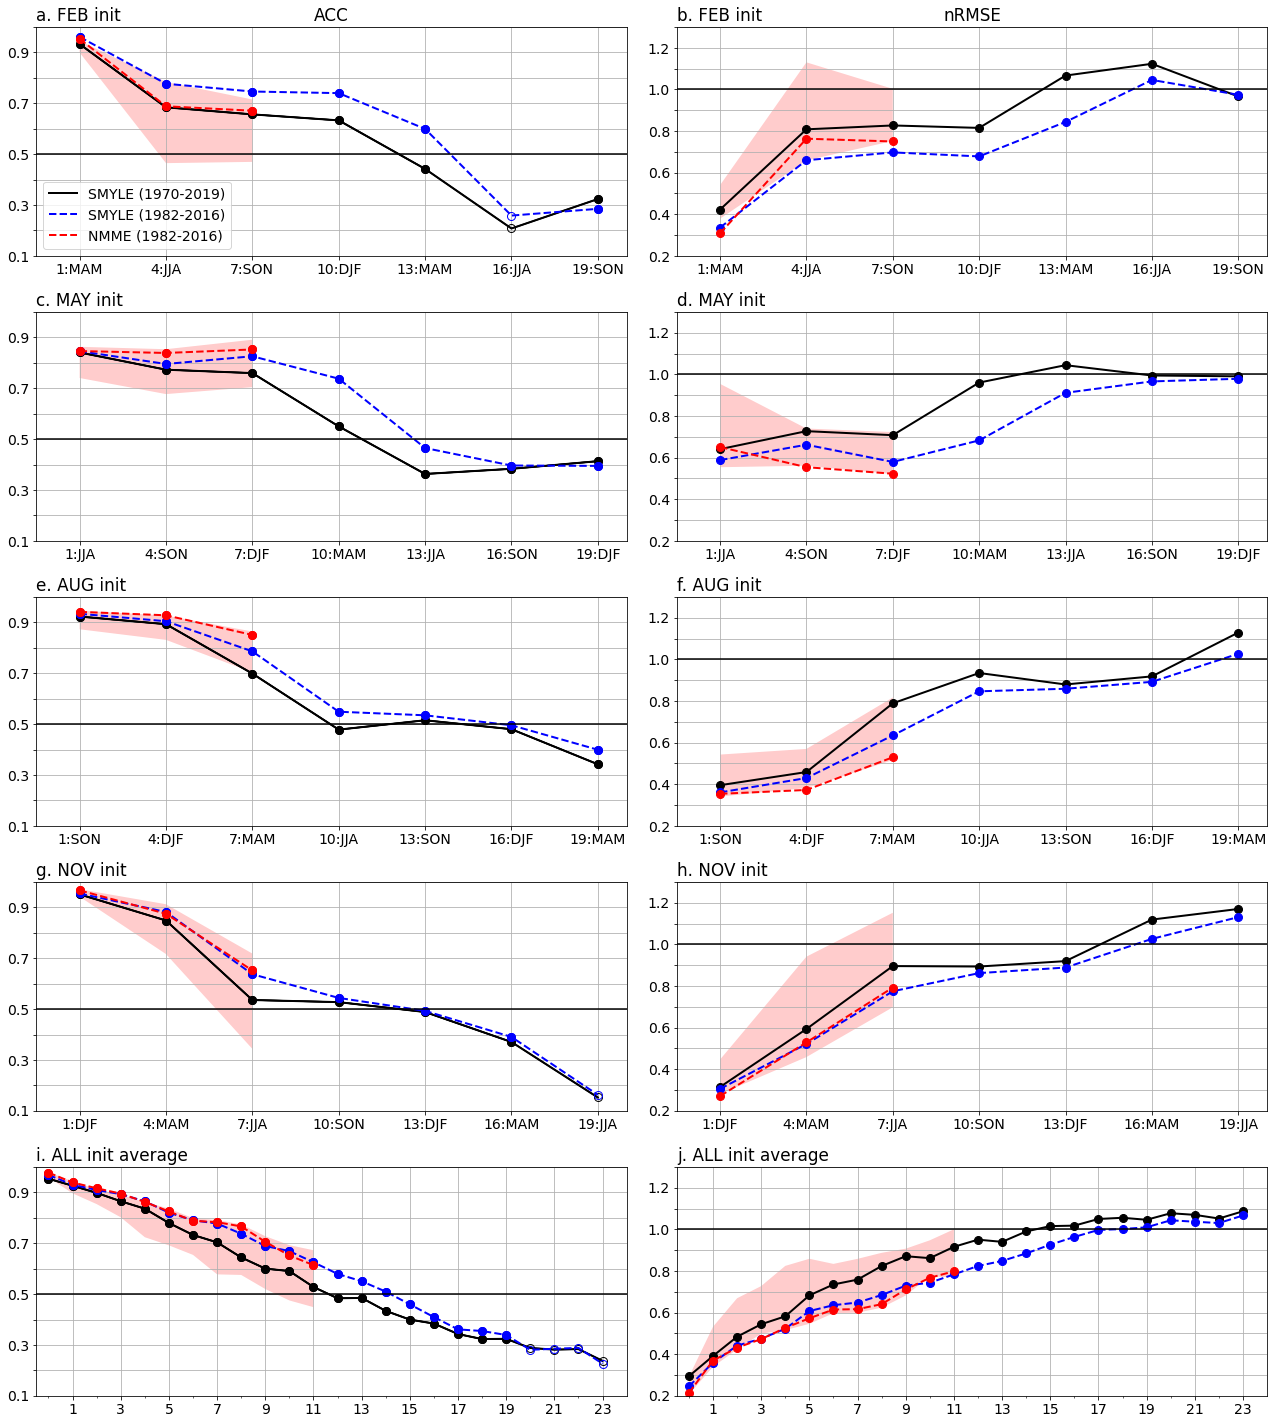

In [57]:
# plot skill scores
fig = plt.figure(figsize=(18,20))
plt.rcParams['font.size'] = '14'
leadsea = smyle11_seas_skill.L[0:-1]-2
leadmon = smyle11_skill.L-1
seasons = ['DJF','MAM','JJA','SON']
xsea = [['MAM','JJA','SON','DJF','MAM','JJA','SON'],\
        ['JJA','SON','DJF','MAM','JJA','SON','DJF'],\
        ['SON','DJF','MAM','JJA','SON','DJF','MAM'],\
        ['DJF','MAM','JJA','SON','DJF','MAM','JJA']]
markers = ['D','o','s','P']
colors = ['k','r','g','b']
hindcasts = ['FEB init','MAY init','AUG init','NOV init','ALL init average']
figlabs = [['a.','c.','e.','g.','i.'],['b.','d.','f.','h.','j.']]

ncol = 2
nrow = 5

for j in range(4):
    ax = fig.add_subplot(nrow,ncol,j*2+1)
    ax2 = fig.add_subplot(nrow,ncol,j*2+2)
    ax.set_title(figlabs[0][j]+' '+ hindcasts[j],loc='left')
    ax2.set_title(figlabs[1][j]+' '+ hindcasts[j],loc='left')
    if (j==0):
        ax.set_title('ACC',loc='center')
        ax2.set_title('nRMSE',loc='center')
    
    tmp = smyle_seas_skill.isel(startmonth=j)
    ax.plot(tmp.L-2,tmp.corr,color='k',linewidth=2,label='SMYLE (1970-2019)')
    ax.plot(tmp.L-2,tmp.corr,color='k',marker='o',markersize=8,fillstyle='none')
    ax.plot(tmp.L-2,tmp.corr.where(tmp.pval<0.1),color='k',marker='o',markersize=8)
    ax2.plot(tmp.L-2,tmp.rmse,color='k',linewidth=2,marker='o',markersize=8)
    
    tmp = smyle_seas_skill_nmme.isel(startmonth=j)
    ax.plot(tmp.L-2,tmp.corr,color='b',linewidth=2,linestyle='--',label='SMYLE (1982-2016)')
    ax.plot(tmp.L-2,tmp.corr,color='b',marker='o',markersize=8,fillstyle='none',linestyle='none')
    ax.plot(tmp.L-2,tmp.corr.where(tmp.pval<0.1),color='b',marker='o',markersize=8,linestyle='none')
    ax2.plot(tmp.L-2,tmp.rmse,color='b',linewidth=2,marker='o',markersize=8,linestyle='--')
    
    tmp = nmme_seas_skill_mmm.isel(startmonth=j)
    ax.plot(tmp.L-2,tmp.corr,color='r',linewidth=2,linestyle='--',label='NMME (1982-2016)')
    ax.plot(tmp.L-2,tmp.corr,color='r',marker='o',markersize=8,fillstyle='none',linestyle='none')
    ax.plot(tmp.L-2,tmp.corr.where(tmp.pval<0.1),color='r',marker='o',markersize=8,linestyle='none')
    ax2.plot(tmp.L-2,tmp.rmse,color='r',linewidth=2,marker='o',markersize=8,linestyle='--')
    tmp = nmme_seas_skill.isel(startmonth=j)
    ymin = tmp.corr.min('model'); ymax = tmp.corr.max('model')
    ax.fill_between(tmp.L.data-2,ymin,ymax,fc='r',alpha=0.2)
    ymin = tmp.rmse.min('model'); ymax = tmp.rmse.max('model')
    ax2.fill_between(tmp.L.data-2,ymin,ymax,fc='r',alpha=0.2)
    
    ax.set_xticks(leadsea)
    xticklabs = (str(leadsea[i].data)+':'+xsea[j][i] for i in range(leadsea.sizes['L']))
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(np.arange(10)*0.1+0.1)
    ax.set_yticklabels(['0.1','','0.3','','0.5','','0.7','','0.9',''])
    ax.set_xlim([-0.5,20])
    ax.set_ylim([0.1,1])
    ax.grid(True)
    ax.axhline(y=0.5, color="black")
    if j==0: leg1 = ax.legend(loc='lower left')
    
    ax2.set_xticks(leadsea)
    xticklabs = (str(leadsea[i].data)+':'+xsea[j][i] for i in range(leadsea.sizes['L']))
    ax2.set_xticklabels(xticklabs)
    ax2.set_yticks(np.arange(12)*0.1+0.2)
    ax2.set_yticklabels(['0.2','','0.4','','0.6','','0.8','','1.0','','1.2',''])
    ax2.set_xlim([-0.5,20])
    ax2.set_ylim([0.2,1.3])
    ax2.grid(True)
    ax2.axhline(y=1.0, color="black")
    
ax = fig.add_subplot(nrow,ncol,4*2+1)
ax2 = fig.add_subplot(nrow,ncol,4*2+2)
ax.set_title(figlabs[0][4]+' '+ hindcasts[4],loc='left')
ax2.set_title(figlabs[1][4]+' '+ hindcasts[4],loc='left')
tmp = smyle_skill.mean('startmonth')
ax.plot(tmp.L-1,tmp.corr,color='k',linewidth=2)
ax.plot(tmp.L-1,tmp.corr,color='k',marker='o',markersize=8,fillstyle='none')
ax.plot(tmp.L-1,tmp.corr.where(tmp.pval<0.1),color='k',marker='o',markersize=8)
ax2.plot(tmp.L-1,tmp.rmse,color='k',linewidth=2,marker='o',markersize=8)
    
tmp = smyle_skill_nmme.mean('startmonth')
ax.plot(tmp.L-1,tmp.corr,color='b',linewidth=2,linestyle='--')
ax.plot(tmp.L-1,tmp.corr,color='b',marker='o',markersize=8,fillstyle='none',linestyle='none')
ax.plot(tmp.L-1,tmp.corr.where(tmp.pval<0.1),color='b',marker='o',markersize=8,linestyle='none')
ax2.plot(tmp.L-1,tmp.rmse,color='b',linewidth=2,marker='o',markersize=8,linestyle='--')
    
tmp = nmme_skill_mmm.mean('startmonth')
ax.plot(tmp.L-1,tmp.corr,color='r',linewidth=2,linestyle='--')
ax.plot(tmp.L-1,tmp.corr,color='r',marker='o',markersize=8,fillstyle='none',linestyle='none')
ax.plot(tmp.L-1,tmp.corr.where(tmp.pval<0.1),color='r',marker='o',markersize=8,linestyle='none')
ax2.plot(tmp.L-1,tmp.rmse,color='r',linewidth=2,marker='o',markersize=8,linestyle='--')
tmp = nmme_skill.mean('startmonth')
ymin = tmp.corr.min('model',skipna=True); ymax = tmp.corr.max('model',skipna=True)
ax.fill_between(tmp.L.data-1,ymin,ymax,fc='r',alpha=0.2)
ymin = tmp.rmse.min('model',skipna=True); ymax = tmp.rmse.max('model',skipna=True)
ax2.fill_between(tmp.L.data-1,ymin,ymax,fc='r',alpha=0.2)
    
ax.set_xticks(np.arange(12)*2+1)
ax.set_xticks(np.arange(12)*2,minor=True)
ax.set_yticks(np.arange(10)*0.1+0.1)
ax.set_yticklabels(['0.1','','0.3','','0.5','','0.7','','0.9',''])
ax.set_xlim([-0.5,24])
ax.set_ylim([0.1,1])
ax.grid(True)
ax.axhline(y=0.5, color="black")
ax2.set_xticks(np.arange(12)*2+1)
ax2.set_xticks(np.arange(12)*2,minor=True)
ax2.set_yticks(np.arange(12)*0.1+0.2)
ax2.set_yticklabels(['0.2','','0.4','','0.6','','0.8','','1.0','','1.2',''])
ax2.set_xlim([-0.5,24])
ax2.set_ylim([0.2,1.3])
ax2.grid(True)
ax2.axhline(y=1.0, color="black")

fig.tight_layout()    
plt.savefig('f03.png')

### Figure 4

#### Include DJF 2021 in obs for timeseries plot

In [21]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc')
nt = np.size(ds_hadisst.time)
time1 = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
time2 = [cftime.DatetimeNoLeap(2021, 1+month, 15) for month in range(5)]
hadisst_montime_vals = np.concatenate((time1,time2))
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])

In [22]:
ds_hadisst.time

<xarray.DataArray 'time' (time: 1817)>
array([cftime.DatetimeNoLeap(1870, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1870, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1870, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2021, 3, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 5, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1870-01-15 00:00:00 ... 2021-05-15 00:00:00

In [23]:
# Note that latitude decreases with index in this dataset!
ds_hadisst = ds_hadisst.rename({"latitude":"lat","longitude":"lon"})
ds_hadisst = ds_hadisst.reindex(lat=ds_hadisst.lat[::-1])

In [24]:
tmp = ds_hadisst.sst.sel(lat=slice(regionlonlat[2],regionlonlat[3])).sel(lon=slice(regionlonlat[0],regionlonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_mon = tmp.weighted(wgts).mean(("lon", "lat"))

In [25]:
obs_seas = obs_mon.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [26]:
jan = obs_seas.time.dt.month==1
obs_djf = obs_seas.where(jan).dropna('time')
obs_djf = obs_djf - obs_djf.sel(time=slice("1982","2016")).mean('time')

In [42]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
smyle_seas_skill = xr.concat([smyle11_seas_skill,smyle08_seas_skill,smyle05_seas_skill,smyle02_seas_skill],dim=startmonth)
smyle_seas = xr.concat([smyle11_seas_regsst_dd,smyle08_seas_regsst_dd,smyle05_seas_regsst_dd,smyle02_seas_regsst_dd],dim=startmonth)
smyle_seas_time = xr.concat([smyle11_seas_time,smyle08_seas_time,smyle05_seas_time,smyle02_seas_time],dim=startmonth)

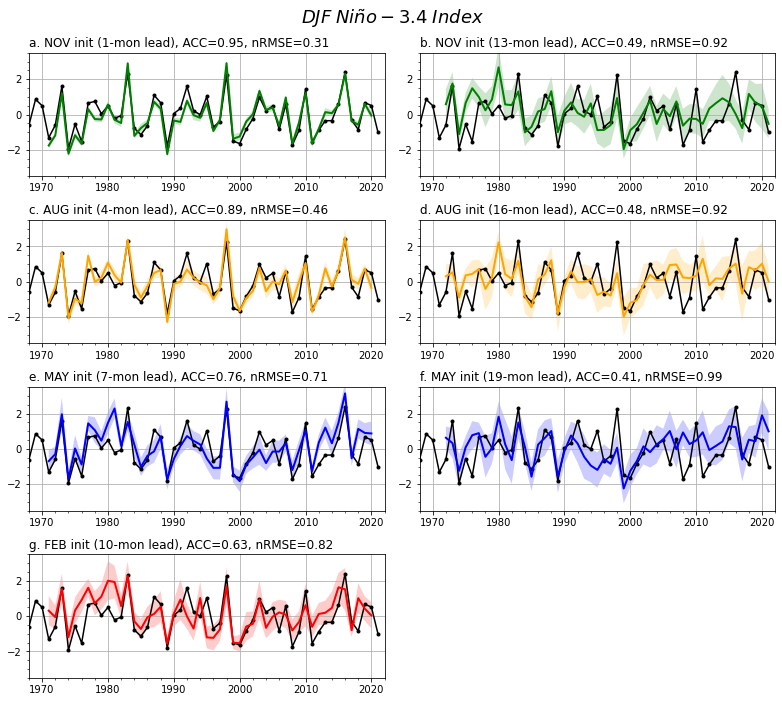

In [82]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10*1.1,9*1.1))

nrow=4
ncol=2
plt.rcParams.update({'font.size': 10})
hindcasts = ['NOV','AUG','MAY','FEB']
djfleadindex = [0,1,2,3]
colors = ['g','orange','b','r']
figlabs = [['a.','c.','e.','g.','i.'],['b.','d.','f.','h.','j.']]
for i in range(nrow):
        ax = fig.add_subplot(nrow,ncol,i*2+1)
        ax.set_ylim([-3.5,3.5])
        ax.set_yticks([-2,0,2])
        ax.set_yticks(np.arange(-3.5,4,0.5),minor=True)
        ax.set_xlim([1968,2022])
        ax.set_xticks(np.arange(1968,2024,2),minor=True)
        ax.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6)
        
        Lindex = djfleadindex[i]
        lead = smyle_seas.isel(startmonth=i).isel(L=Lindex).L.values.item()-2
        acc = smyle_seas_skill.isel(startmonth=i).isel(L=Lindex).corr.values.item()
        nrmse = smyle_seas_skill.isel(startmonth=i).isel(L=Lindex).rmse.values.item()
        data = smyle_seas.isel(startmonth=i).isel(L=Lindex)
        datatime = smyle_seas_time.isel(startmonth=i).isel(L=Lindex).dt.year
        titl = hindcasts[i]+' init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
        ax.set_title(figlabs[0][i]+' '+titl, loc='left')
        ax.plot(datatime,data.mean('M'),color=colors[i],linewidth=2)
        datastd = data.std('M')
        ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
        ax.fill_between(datatime,ymin,ymax,fc=colors[i],alpha=0.2)
        ax.grid(True)
        
        if (i<3):
            ax2 = fig.add_subplot(nrow,ncol,i*2+2)
            ax2.set_ylim([-3.5,3.5])
            ax2.set_yticks([-2,0,2])
            ax2.set_yticks(np.arange(-3.5,4,0.5),minor=True)
            ax2.set_xlim([1968,2022])
            ax2.set_xticks(np.arange(1968,2024,2),minor=True)
            ax2.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6)
            
            Lindex = djfleadindex[i]+4
            lead = smyle_seas.isel(startmonth=i).isel(L=Lindex).L.values.item()-2
            acc = smyle_seas_skill.isel(startmonth=i).isel(L=Lindex).corr.values.item()
            nrmse = smyle_seas_skill.isel(startmonth=i).isel(L=Lindex).rmse.values.item()
            data = smyle_seas.isel(startmonth=i).isel(L=Lindex)
            datatime = smyle_seas_time.isel(startmonth=i).isel(L=Lindex).dt.year
            titl = hindcasts[i]+' init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
            ax2.set_title(figlabs[1][i]+' '+titl, loc='left')
            ax2.plot(datatime,data.mean('M'),color=colors[i],linewidth=2)
            datastd = data.std('M')
            ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
            ax2.fill_between(datatime,ymin,ymax,fc=colors[i],alpha=0.2)
            ax2.grid(True)
        
fig.suptitle(r'$DJF\;Ni\tilde{n}o-3.4\;Index$',fontsize=18)
fig.tight_layout()
plt.savefig('f04.png')